# Ajuste de modelos via cuadrados mínimos usando PyTorch

## Ejercicio 1)

Instale `pytorch` usando el comando de bash

## Ejercicio 2)

**1)** Importe librerias `numpy`, `scipy` y `matplotlib`.

**2)** Importe librerias de `pytorch`.
Para ello, vea el colab `pytorch-tutorial-1-tensores.ipynb`.

In [275]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [276]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torchviz import make_dot
import torch.optim as optim

## Ejercicio 3)

Considere una secuencia de mediciones $(x_i,y_i)$ con $i=1,...,m$ de una variable independiente $x$ y una variable dependiente $y$.

Considere un modelo

$$
y = f(x,w) = \exp(-w_0 x)\sin(w_1x)
$$

donde $w=(w_0,w_1)$ es el vector de los parámetros del modelo.

**1)** Use `np.linspace` para generar un vector de 20 valores de $x$ en $[0,3]$.

**2)** Con $w=(0.5,4)$, use los valores de $x$ para generar un vector de 30 valores de $y$, i.e. un vector de componentes $y_i = f(x_i,w)$.

**3)** Genere valores experimentales *sintéticos* agregando ruido al vector $y$ generado en **2)**, agregandole números aleatorios obtenidos de una distribución normal de media $0$ y desviación estandard $0.1$.

**4)** Grafique los datos *experimentales* usando puntos.
Simultaneamente, grafique la curva *exacta*, interpolando sobre 300 puntos en el mismo rango.

In [277]:
# 3.1)
# genero 30 puntos en el intervalo [0,3] (para poder generar 30 valores de y)
def f_ej3(x,w):
    return np.exp(-w[0]*x) * np.sin(w[1]*x)

x_vec = np.linspace(0,3,30)
w_exacto = np.array([0.5, 4])
y_vec = f_ej3(x_vec,w_exacto)

# generar valores experimentales sinteticos agregando ruido a y (media 0 y desviacion 0.1)
y_noisy = y_vec + 0.1*np.random.randn(30)

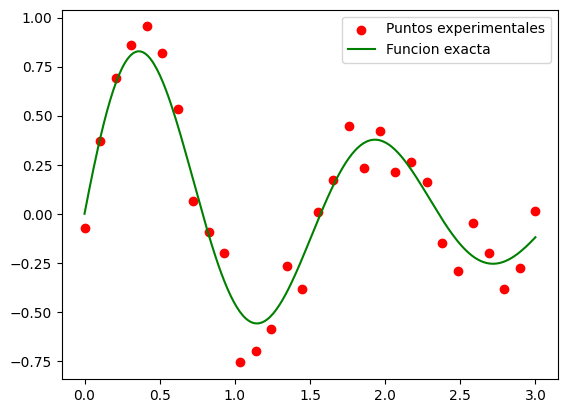

In [278]:
# grafiar los puntos experimentales y la funcion interpolante
x_vec_300 = np.linspace(0,3,300)
y_exacto = f_ej3(x_vec_300,w_exacto)
plt.scatter(x_vec, y_noisy, c='r', label='Puntos experimentales')
plt.plot(x_vec_300, y_exacto, 'g', label='Funcion exacta')
plt.legend()
plt.show()

## Ejercicio 4)

El ajuste de un modelo por cuadrados mínimos, consiste en encontrar el vector de parámetros que minimiza la suma de los cuadrados de las diferencias entre los datos y las predicciones del modelo.
Más precisamente, consiste en minimizar

$$
E(w) = \sum_i (f(x_i,w)-y_i)^2
$$

con respecto a $w$.

**1)** Minimice $E(w)$ utilizando el algoritmo del descenso por el gradiente.
Implemente el algoritmo utilizando `pytorch`. Saque ventaja de la capacidad de `pytorch` de calcular gradientes de manera automática. Utilice un learning rate $\eta=0.001$ y como valores iniciales de $w$, los originales, pero levemente perturbados con un números aleatorios obtenidos de una distribución normal de media $1$ y desviación estandard $0.25$.

**2)** Grafique, utilizando los mismos 300 puntos de antes, la curva ajustada por el algoritmo anterior.

In [279]:
# defino la funcion f para tensor
def f_torch(x,w):
    return torch.exp(-w[0]*x) * torch.sin(w[1]*x)

def ecm_torch(x, y, w):
    """ 
     x: tensor con los valores de x
     y: tensor con los valores de y
     w: tensor con los valores de w

    retorna el error cuadratico medio para los valores de w que buscan ajustar la funcion f(x,w) a los valores de y
    """
    pred = f_torch(x,w)
    return torch.sum((pred - y)**2)

In [280]:
# 4.1)
# Utilizando pytorch minimizar el error cuadratico medio entre f(x,w) y los valores con ruido (y_noisy)
def ej_4 (x, y, w, ecm, epochs=1000):
    """ 
    x: valores de x para entrenar
    y: valores de y a los que se quiere ajustar
    w: valores iniciales de w
    ecm: funcion de error cuadratico medio (para usar con tensores y pytorch)
    epochs: cantidad de epocas a entrenar
     
    Return:
    w: valores de w ajustados
    ecm: errores cuadraticos medios por cada epoca
    """
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # defino los w iniciales
    w_tensor = torch.tensor(w, requires_grad=True, dtype=torch.float32)

    # defino el optimizador
    optimizer = optim.SGD([w_tensor], lr=0.001)
    
    epochs_ecm = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = ecm(x_tensor, y_tensor, w_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Loss {loss}, w: {w_tensor}')
            epochs_ecm.append(loss.detach().numpy())

    print(f'W final: {w_tensor}')
    return w_tensor, epochs_ecm

Epoch 0: Loss 3.417505979537964, w: tensor([1.5573, 5.0377], requires_grad=True)
Epoch 100: Loss 3.112346887588501, w: tensor([1.5084, 4.8701], requires_grad=True)
Epoch 200: Loss 2.782665252685547, w: tensor([1.4309, 4.7061], requires_grad=True)
Epoch 300: Loss 2.4141736030578613, w: tensor([1.3228, 4.5476], requires_grad=True)
Epoch 400: Loss 1.9905931949615479, w: tensor([1.1817, 4.3981], requires_grad=True)
Epoch 500: Loss 1.5005106925964355, w: tensor([1.0064, 4.2630], requires_grad=True)
Epoch 600: Loss 0.9725712537765503, w: tensor([0.8056, 4.1519], requires_grad=True)
Epoch 700: Loss 0.5553395748138428, w: tensor([0.6167, 4.0772], requires_grad=True)
Epoch 800: Loss 0.40023013949394226, w: tensor([0.5011, 4.0430], requires_grad=True)
Epoch 900: Loss 0.37951651215553284, w: tensor([0.4599, 4.0332], requires_grad=True)
Epoch 1000: Loss 0.3781599998474121, w: tensor([0.4495, 4.0312], requires_grad=True)
Epoch 1100: Loss 0.37809133529663086, w: tensor([0.4471, 4.0309], requires_gra

[]

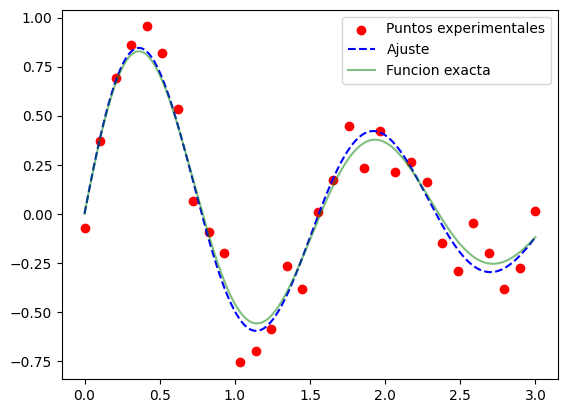

In [281]:
# graficar los puntos originales contra la funcion ajustada con los valores de w encontrados
w_noisy = w_exacto + 1+0.1*np.random.randn(2)

w_ej4, ecm_ej4 = ej_4(x_vec, y_noisy, w_noisy, ecm_torch,epochs=3000)

y_pred_ej4 = f_ej3(x_vec_300, w_ej4.detach().numpy())

plt.scatter(x_vec, y_noisy, c='r', label='Puntos experimentales')
plt.plot(x_vec_300, y_pred_ej4, 'b', label='Ajuste', linestyle='--')
plt.plot(x_vec_300, y_exacto, 'g', label='Funcion exacta', alpha=0.5)
 
plt.legend()
plt.plot()

## Ejercicio 5)

**1)** Repita el ejercicio anterior, pero ahora ajustando el modelo

$$
f(x,w) = \exp(-w_0x+w_2)\sin(w_1x+w_3)
$$

i.e. un modelo con dos parámetros ajustables extra.

**2)** Calcule el error cuadratico medio de ambos modelos, sobre los 30 puntos de entrenamiento y sobre los 300 puntos del la curva exacta.

In [282]:
# 5.1)
def f_ej5(x,w):
    return np.exp(-w[0]*x + w[2]) * np.sin(w[1]*x + w[3])

def f_torch_ej5(x, w):
    return torch.exp(-w[0]*x + w[2]) * torch.sin(w[1]*x + w[3])

def ecm_torch_ej5(x, y, w):
    pred = f_torch_ej5(x,w)
    return torch.sum((pred - y)**2)

[0.8345074  5.06988136 0.1        0.1       ]
Epoch 0: Loss 4.412659645080566, w: tensor([0.8376, 5.0655, 0.0979, 0.0947], requires_grad=True)
Epoch 100: Loss 1.7763646841049194, w: tensor([ 0.9063,  4.7105,  0.1154, -0.2209], requires_grad=True)
Epoch 200: Loss 0.9282779097557068, w: tensor([ 0.8147,  4.4733,  0.2231, -0.2900], requires_grad=True)
Epoch 300: Loss 0.5782713890075684, w: tensor([ 0.7269,  4.3234,  0.2724, -0.2592], requires_grad=True)
Epoch 400: Loss 0.4457463026046753, w: tensor([ 0.6761,  4.2348,  0.2712, -0.2104], requires_grad=True)
Epoch 500: Loss 0.3884844481945038, w: tensor([ 0.6456,  4.1817,  0.2540, -0.1709], requires_grad=True)
Epoch 600: Loss 0.3609328866004944, w: tensor([ 0.6240,  4.1484,  0.2352, -0.1428], requires_grad=True)
Epoch 700: Loss 0.34676361083984375, w: tensor([ 0.6074,  4.1269,  0.2186, -0.1233], requires_grad=True)
Epoch 800: Loss 0.3390944004058838, w: tensor([ 0.5942,  4.1126,  0.2046, -0.1097], requires_grad=True)
Epoch 900: Loss 0.334780

[]

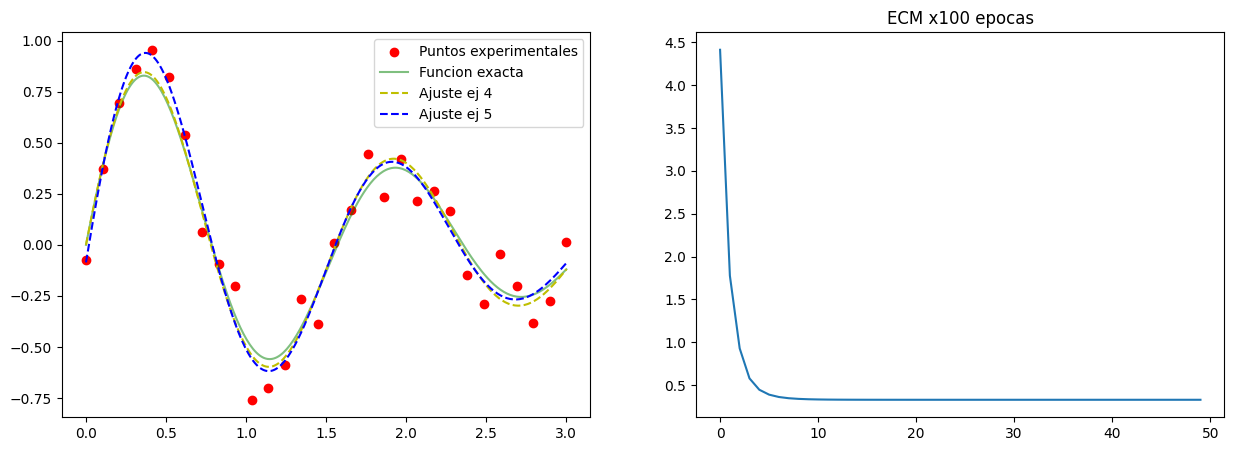

In [284]:
w_noisy = w_exacto + np.random.normal(1,0.5, 2)
w_noisy = np.append(w_noisy, [0.1,0.1])
print(w_noisy)

w_ej5, ecm_ej5 = ej_4(x_vec, y_noisy, w_noisy, ecm_torch_ej5, epochs=5000)

# normalize the ecm values to plot them
ecm_ej5 = np.array(ecm_ej5)

y_pred_ej5 = f_torch_ej5(torch.tensor(x_vec_300, dtype=torch.float32),w_ej5).detach().numpy()

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(x_vec, y_noisy, c='r', label='Puntos experimentales')
ax[0].plot(x_vec_300, y_exacto, 'g', label='Funcion exacta', alpha=0.5)

ax[0].plot(x_vec_300, y_pred_ej4, 'y', label='Ajuste ej 4', linestyle='--')
ax[0].plot(x_vec_300, y_pred_ej5, 'b', label='Ajuste ej 5', linestyle='--')
ax[0].legend()

ax[1].plot(np.array(ecm_ej5))
ax[1].set_title('ECM x100 epocas')
plt.plot()